##### Goal: To identify common themes and narratives from a series of response texts

##### Author: Israel Ilori

In [1]:
"""
Approach: 
    1. Read in the data
    2. Explore dataset (check for missing sentences, duplicates)
    3. Generate Theme representation from documents/response texts using a pre-trained transformer model (BERTopic - a transformer based NLP model for extracting Topics from documents). 
    How?
        a. convert documents/response texts to numerical format using sentence-level embeddings - SentenceTransformer.
        b. reduce dimensionality of embeddings for optimization of the clustering process - UMAP.
        c. cluster documents/response texts with similar themes together, and assign theme to individual clusters - HDBSCAN.
        d. extract topic representations from clusters - a class-based variation of TF-IDF.
"""

# import packages
import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/Users/tosi-n/Downloads/izzy/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in data into pandas
data = pd.read_csv('coded_responses.csv')

data.head()

,question,respondent_id,response,theme
0,Why are you cancelling?,1779533,seen what I like already,NaN
1,Why are you cancelling?,1779397,"You keep canceling really good, popular series!",NaN
2,Why are you cancelling?,1779811,Getting through cell provider,NaN
3,Why are you cancelling?,1779968,Budget cuts,Reducing expenses / financial constraints
4,Why are you cancelling?,1779967,Cannot have multiple users,Object to sharing restrictions


In [3]:
# check the distribution of the respondent id to reponses
duplicate = data[data.duplicated()] 

print ("Duplicate Rows :", duplicate)
# Print the resultant Dataframe


Duplicate Rows : Empty DataFrame
Columns: [question, respondent_id, response, theme]
Index: []


In [4]:
# in here, we use distilbert pre-trained model available on HuggingFace - it gives a great balance between speed and effective performance
# since we are mainly interested in the response texts, we filter it out to use in our embedding
""" 
    convert documents/response texts to numerical format using sentence-level embeddings - SentenceTransformer.
"""
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data['response'], show_progress_bar=True)

Batches: 100%|██████████| 21/21 [00:02<00:00,  9.13it/s]


In [5]:
""" 
    reduce dimensionality of embeddings for optimization of the clustering process - UMAP.
"""
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [6]:
""" 
    cluster documents/response texts with similar themes together, and assign theme to individual clusters - HDBSCAN.
"""
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

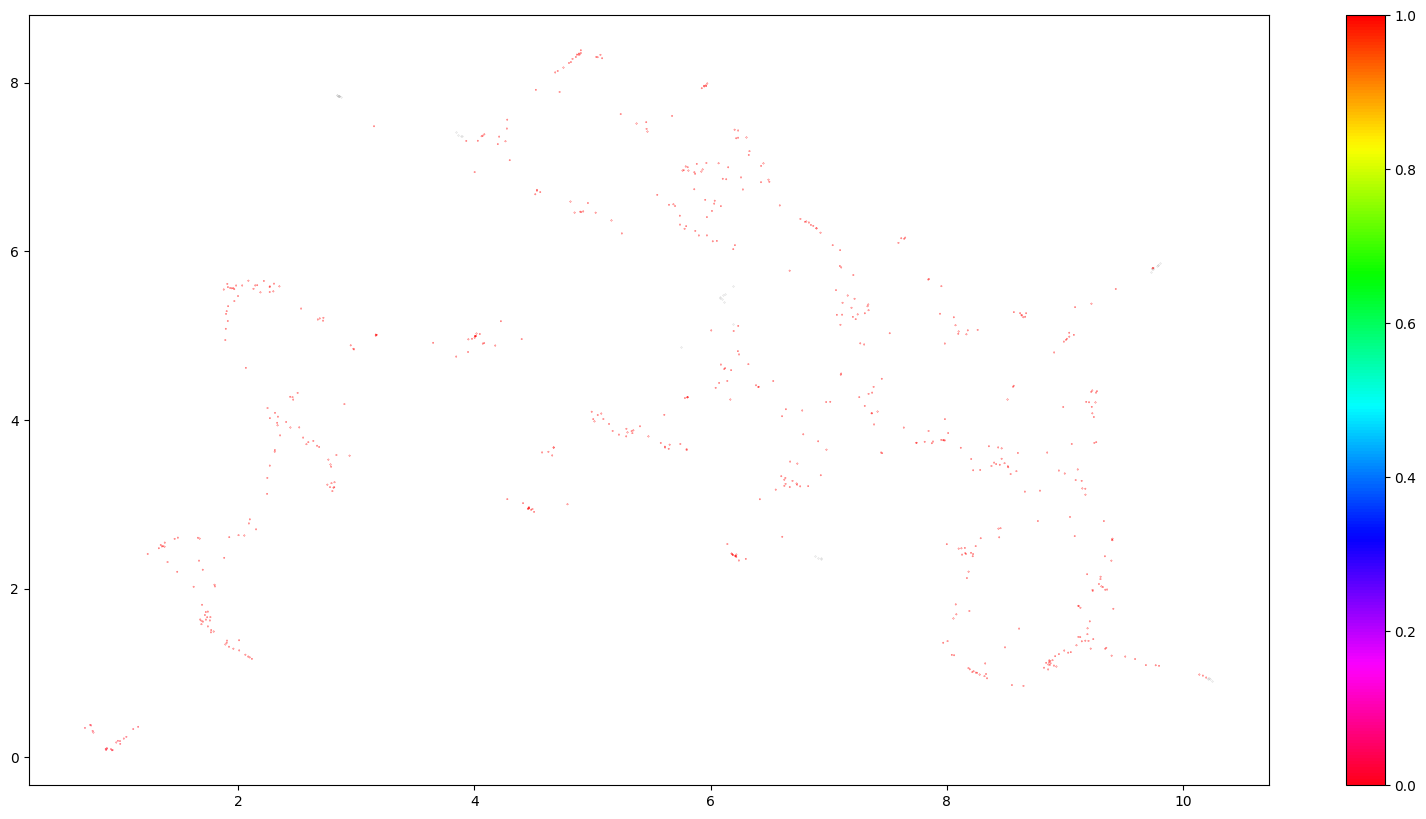

In [19]:

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [20]:
"""
    extract topic representations from clusters - a class-based variation of TF-IDF.
"""

docs_df = pd.DataFrame(data, columns=["response"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'response': ' '.join})

In [21]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

""" 
    create importance for each word in the cluster
    we use a class-based approach because the responses are part of a larger cluster and as such we want to group them by joining all responses in a cluster together
"""

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.response.values, m=len(data))

In [22]:
"""
    Create function to extract the top 20 words for each topic - the value of n can be increased to get more words
    Create function to get the frequency distribution for each topic 
"""
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .response
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "response": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
2,1,602
0,-1,41
1,0,20


In [28]:
top_n_words[1][:]

[('price', 0.09556218695100391),
 ('subscription', 0.06511608463552891),
 ('prices', 0.05205067460931001),
 ('increase', 0.04789881205305244),
 ('increases', 0.047839192613557485),
 ('need', 0.047381023146162334),
 ('money', 0.04615603781993019),
 ('don', 0.04384443838529867),
 ('subscriptions', 0.04002881947096716),
 ('expensive', 0.03912901475663285),
 ('sharing', 0.038233658215742164),
 ('raising', 0.035580713123846607),
 ('use', 0.0336883381048844),
 ('anymore', 0.03253757171590959),
 ('service', 0.03253757171590959),
 ('worth', 0.03253757171590959),
 ('new', 0.031363561435580396),
 ('just', 0.030881031635791745),
 ('going', 0.03047992495203827),
 ('time', 0.028062133916045617)]

In [29]:
top_n_words[-1][:]

[('extra', 0.166560606111311),
 ('charging', 0.10467318988941847),
 ('share', 0.10467318988941847),
 ('subscription', 0.10444458196446577),
 ('charge', 0.09863578721321255),
 ('using', 0.09253367006183943),
 ('family', 0.08659942375048349),
 ('pay', 0.08643293419517262),
 ('greedy', 0.07492340949297513),
 ('people', 0.06740272513241702),
 ('hikes', 0.057312404862826606),
 ('months', 0.05616893761034751),
 ('inflation', 0.05377160595380352),
 ('like', 0.0532026609706583),
 ('raising', 0.052504933469155135),
 ('price', 0.050725548115575024),
 ('increase', 0.046501463250301744),
 ('reason', 0.04626996601300931),
 ('newest', 0.04626996601300931),
 ('checking', 0.04626996601300931)]

In [30]:
top_n_words[0][:]

[('break', 0.9822619823550209),
 ('taking', 0.7590517995162022),
 ('summer', 0.4525312109029409),
 ('coming', 0.2149491781342932),
 ('laid', 0.1892770603357767),
 ('just', 0.17580947111170325),
 ('got', 0.15534036656265987),
 ('ll', 0.15181035990324043),
 ('time', 0.13156800040812672),
 ('play', 0.12031064796640485),
 ('monetary', 0.12031064796640485),
 ('layoff', 0.12031064796640485),
 ('bit', 0.12031064796640485),
 ('activities', 0.1074745890671466),
 ('health', 0.09996597595403245),
 ('broke', 0.09463853016788835),
 ('saving', 0.09050624218058818),
 ('come', 0.09050624218058818),
 ('outside', 0.09050624218058818),
 ('better', 0.0818024712686301)]

### *** Don't run the cell below, I discovered it only reduces the size of topic termms created. You only have 3 topic terms created check distributions above. Last cell squeezes it down to 1 considering data for training is very limited ***

In [31]:
# from sklearn.metrics.pairwise import cosine_similarity
# for i in range(20):
#     # Calculate cosine similarity
#     similarities = cosine_similarity(tf_idf.T)
#     np.fill_diagonal(similarities, 0)

#     # Extract label to merge into and from where
#     topic_sizes = docs_df.groupby(['Topic']).count().sort_values("response", ascending=False).reset_index()
#     topic_to_merge = topic_sizes.iloc[-1].Topic
#     topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

#     # Adjust topics
#     docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
#     old_topics = docs_df.sort_values("Topic").Topic.unique()
#     map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
#     docs_df.Topic = docs_df.Topic.map(map_topics)
#     docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'response': ' '.join})

#     # Calculate new topic words
#     m = len(data)
#     tf_idf, count = c_tf_idf(docs_per_topic.response.values, m)
#     top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

# topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)